In [40]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
import xrfdc #poorly documented library that handles interfacing to the RF data converter
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file
# import pprint
# pprint.pprint(ol.ip_dict)
dma = ol.axi_dma_0 #might need to change name depending on what you called it
rf = ol.usp_rf_data_converter_0 #might need to change name depending on what you called it

In [41]:
#utility func
import numpy as np
import time
%matplotlib notebook
import matplotlib.pyplot as plt
from pynq import allocate
import math

def plot_to_notebook(time_sec,in_signal,n_samples,):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-o',label='Input signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-o',label='Input signal')

    plt.legend()
def iq_plot(time_sec,re_signal,im_signal,n_samples,):
    samp = [i for i in range(n_samples)]
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
#     plt.plot(time_sec[:n_samples],re_signal[:n_samples],'y-o',label='I signal')
#     plt.plot(time_sec[:n_samples],im_signal[:n_samples],'g-o',label='Q signal')
    plt.plot(samp,re_signal[:n_samples],'y-o',label='I signal')
    plt.plot(samp,im_signal[:n_samples],'g-o',label='Q signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-o',label='Input signal')

    plt.legend()

def plot_fft(samples,in_signal,n_samples,):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Frequency')
    plt.grid()
    plt.plot(samples[:n_samples],in_signal[:n_samples],'y-',label='Signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Signal')
    plt.legend()

def bins(num):
    """Converts an integer to its signed binary representation."""

    if num >= 0:
        return bin(num)[2:]  # Remove the '0b' prefix
    else:
        # Use two's complement for negative numbers
        return bin(2**16 + num)[2:]  # Assuming 32-bit representation
    
def pack_IQ(i, q):
    '''
        IQ data is packed as follows:
        [IIIIIIIIIIIIII..QQQQQQQQQQQQQQ..]
        [<---14-bits-->  <---14-bits-->  ]
        [<-----------32-bits------------>]
    '''
    top = bins(i).rjust(16, '0')
    bottom = bins(q).rjust(16, '0')
#     print(top, bottom, int(top + bottom, 2))
    return int(top + bottom, 2)

def sweep_I(counter=1000, n=65536):
    # sweep I values, keeping Q at 0
    steps = n//counter
    max_iq = 2**12 - 1
    incr = max_iq//steps
    samples = []
    for i in range(steps):
        print(f"at step {i} sending I value {incr*i} as {pack_IQ(incr*i, 0)}")
        for k in range(counter):
            samples.append(pack_IQ(incr*i, 0))
    if (len(samples) < n):
        print("extending")
        samples.extend([pack_IQ(max_iq, 0) for i in range(n-len(samples))])
    elif len(samples) > n:
        samples = samples[:n]
    return samples

def get_phase(gi, gq, ii, iq):
    dot = (gi*ii + gq*iq)
    mag1 = (gi**2 + gq**2)**.5
    mag2 = (ii**2 + iq**2)**.5
    denom = mag1*mag2
    frac = dot/denom
    if frac > 1:
        frac = 1
    elif frac < -1:
        frac = -1
    return math.acos(frac)

def get_360_phase(i, q):
    res = get_phase(1, 0, i, q)*57.2958
    if q < 0:
        res = 360 - res
    return res

def rotate_point(i, q, phase):
    new_i = i*math.cos(phase) - q*math.sin(phase)
    new_q = i*math.sin(phase) + q*math.cos(phase)
    return (new_i, new_q)

def send_packet(mod_freq, sample_rate, data):
    '''
    mod_freq is desired modulation frequency
    sample_rate is sample_rate of DAC
    data is a list of tuples representing IQ data
    '''
    mod_width = 1/mod_freq
    num_samples = int(mod_width*sample_rate)
    samples = []
    # send alternating pattern length 4
    for i in range(4):
        for k in range(num_samples):
            if (i % 2):
                samples.append(pack_IQ(2**15 - 1, 0)) #should be the positive max I and max Q when demodulated
            else:
                samples.append(pack_IQ(0, 2**15 - 1)) #should be negative smallest I and Q value when demodulated
    # send 4 zero pulses after
    for i in range(4):
        for k in range(num_samples):
            samples.append(pack_IQ(0, 0))
    # send data ( a list of tuples)
    for i in data:
        for k in range(num_samples):
            samples.append(pack_IQ(i[0], i[1]))
    # pad with 4 zeros again
    for i in range(4):
        for k in range(num_samples):
            samples.append(pack_IQ(0, 0))
    print(f"Packet len {len(samples)}, num samples per modulation {num_samples}")
    return samples

def read_packet(mod_freq, sample_rate, samples, data_len):
    '''
        state machine that ingests IQ data, determines phase delay based upon
        agreed upon calibration, and reads phase shifted IQ data
        mod_freq : agreed upon modulation frequency
        sample_rate : sample rate of ADC
        samples : samples of IQ data, in zip format
    '''
    mod_width = 1/mod_freq
    num_samples = int(mod_width*sample_rate)
    # mimicking a state machine
    ind = 0
    states = ['P0', 'P1', 'P2', 'P3', 'Z', 'A']
    state = 'P0'
    allowed_error = 100
    allowed_phase_diff = 10 # in degrees
    expected_phase_diff = 90
    allowed_calculated_phase_diff = 5 # in degrees
    p0 = 0
    p1 = 0
    zero_count = 0
    counter = 0
    print(f"attempting to skip {num_samples} per modulation")
    while counter < len(samples):
        if state == 'P0':
            # sample first alternating pattern
            zero_count = 0
            p0 = samples[counter]
            state = 'P1'
            counter += num_samples
        elif state == 'P1':
            # sample second alternating pattern
            p1 = samples[counter]
            phase = get_phase(p0[0], p0[1], p1[0], p1[1])*57.2958 % 360
            if (abs(phase - expected_phase_diff) < allowed_phase_diff):
                state = 'P2'
                counter += num_samples
            else:
                print(f"P1 error break to P0, phase {phase} phase diff {abs(phase - expected_phase_diff)}")
                state = 'P0'
        elif state == 'P2':
            print(p0, p1)
            # time to see if sample is within error of p0
            if (abs(samples[counter][0] - p0[0]) < allowed_error and abs(samples[counter][1] - p0[1]) < allowed_error):
                state = 'P3'
                counter += num_samples
            else:
                print("P2 error break to P0")
                state = 'P0'
        elif state == 'P3':
            # time to see if sample is within error of p1
            if (abs(samples[counter][0] - p1[0]) < allowed_error and abs(samples[counter][1] - p1[1]) < allowed_error):
                state = 'Z'
                counter += num_samples
            else:
                print("P3 error break to P0")
                state = 'P0'
        elif state == 'Z':
            # time to see if sample is within error of zero
            if (zero_count > 2):
                state = 'A'
                #inc to next sample
                counter += num_samples
            elif (abs(samples[counter][0] + samples[counter][1]) < allowed_error):
                counter += num_samples
                zero_count += 1
            else:
                print("Z error break to P0")
                state = 'P0'
        elif state == 'A':
            # check to see if calculated phase delay is in agreement
            #figure out phase from last received calibration sample
            
            # accidentally flipped calibration signal in verilog (compared to python send_packet)
            ref_calibration_p0 = (1, 0)
            ref_calibration_p1 = (0, 1)
            phase_delay_p0 = get_phase(ref_calibration_p0[0], ref_calibration_p0[1], p0[0], p0[1])
            phase_delay_p1 = get_phase(ref_calibration_p1[0], ref_calibration_p1[1], p1[0], p1[1])
            if (abs((phase_delay_p0*57.2958 % 360) - (phase_delay_p1*57.2958 % 360)) < allowed_calculated_phase_diff):
                print("sucess, reading data now")
                break
            else:
                print(f"A error break to P0, phase diff {abs((phase_delay_p0*57.2958 % 360) - (phase_delay_p1*57.2958 % 360))}")
                state = 'P0'
    print(len(samples))
    if (counter == (len(samples)//num_samples + 1)*num_samples):
        print("State machine failed to attach")
        return
    print(f"State machine attached {counter} samples in.")
    # figure out if phase delay is positive or negative
    check_p0_positive = rotate_point(p0[0], p0[1], phase_delay_p0)
    check_p0_negative = rotate_point(p0[0], p0[1], -phase_delay_p0)
    p0_pos_error = abs(check_p0_positive[0] - ref_calibration_p0[0]) + abs(check_p0_positive[1] - ref_calibration_p0[1])
    p0_neg_error = abs(check_p0_negative[0] - ref_calibration_p1[0]) + abs(check_p0_negative[1] - ref_calibration_p1[1])
    if (p0_pos_error < p0_neg_error):
        pos = 1
    else:
        pos = -1
    print(f"P0: {p0} ref phase delay {phase_delay_p0*57.2958 % 360}")
    print(f"P1: {p1} ref phase delay {phase_delay_p1*57.2958 % 360}")
    # finally sample the data received
    # since its qpsk we can just use phase to determine the bit
    lookup = {
        0    : "0000",
        22.5 : "0001",
        45   : "0010",
        67.5 : "0011",
        90   : "0100",
        112.5: "0101",
        135  : "0110",
        157.5: "0111",
        180  : "1000",
        202.5: "1001",
        225  : "1010",
        247.5: "1011",
        270  : "1100",
        292.5: "1101",
        315  : "1110",
        337.5: "1111",
        360  : "0000"
    }
    
    
    #     lookup = {
#         45: "00",
#         135: "01",
#         225: "11",
#         315: "10"
#     }
    data = []
    for i in range(data_len):
        data_old = samples[counter]
        data_new_p0 = rotate_point(data_old[0], data_old[1], pos*phase_delay_p0)
        data_new_p1 = rotate_point(data_old[0], data_old[1], pos*phase_delay_p1)
        print(f"old point {data_old} p0 phase adjusted point {data_new_p0} p1 phase adjusted point {data_new_p1}")
        err = -1
        ind = 0
        for k in lookup:
            test = abs(get_360_phase(data_new_p0[0], data_new_p0[1]) - k)
            if test < err or err < 0:
                err = test
                ind = k
        print(f"Determined bits {lookup[ind]}")
        data.append(lookup[ind])
        counter += num_samples
    return data

In [ ]:
get_360_phase(1, -1)

In [42]:
adc_tile = rf.adc_tiles[2]
adc_block = adc_tile.blocks[0]
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
adc_block.MixerSettings['Freq']= -433 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.

In [43]:
dac_tile = rf.dac_tiles[0]
dac_block = dac_tile.blocks[0]
dac_block.MixerSettings['Freq'] = 433
dac_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.

In [ ]:
# send values over DMA to repeater ip
# after running this, flip switch to start repeating values
# SANITY CHECK SWEEP PATTERN
samples = []
mx = 65536
state = True
for i in range(mx):
    samples.append(pack_IQ(16*i % (2**15 - 1), 0))
print("value samples", samples[0], samples[mx//4 + 1], samples[2*(mx//4) + 1], samples[3*(mx//4) + 1])
in_buffer = allocate(shape=(mx,), dtype=np.int32)
np.copyto(in_buffer,samples)
print(in_buffer)
dma.sendchannel.transfer(in_buffer)
dma.sendchannel.wait()

In [ ]:
# send values over DMA to repeater ip
# after running this, flip switch to start repeating values
# ACTUAL PACKET ATTEMPT
samples = []
mx = 65536
# create a packet with IQ modulation frequency that is 1/100 of DAC sample rate
packet = send_packet(14745.6,1474560, [(2**15 - 1, 0),(0, 0),(0, 0),(0, 2**15)])
num_packets = round(mx/len(packet))
samples.extend(packet*num_packets)
samples = samples[:mx]
in_buffer = allocate(shape=(mx,), dtype=np.int32)
np.copyto(in_buffer,samples)
dma.sendchannel.transfer(in_buffer)
dma.sendchannel.wait()

Hardware execution time:  0.0011169910430908203


<IPython.core.display.Javascript object>


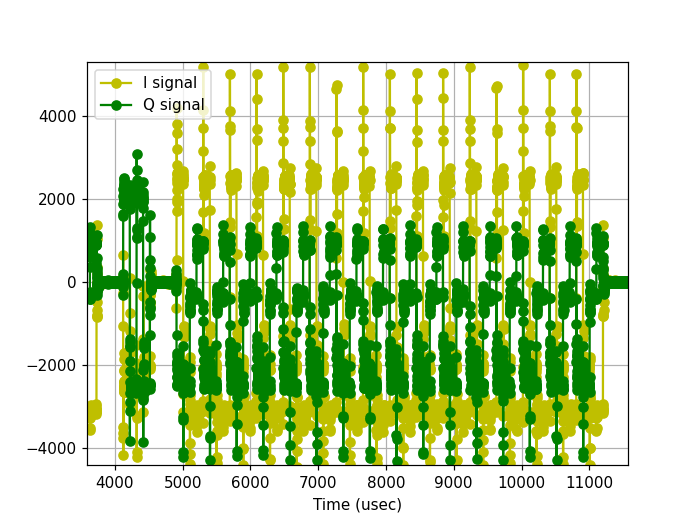

<IPython.core.display.Javascript object>


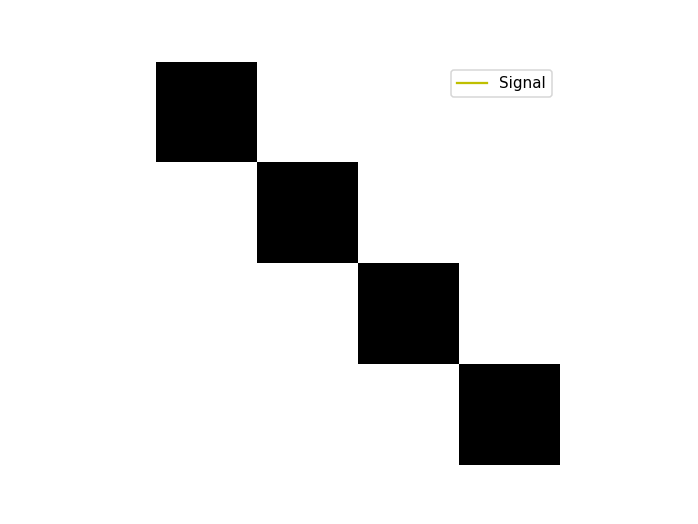

In [45]:
# extract 65k list of IQ samples
# display ADC output
# Sampling frequency
fs = 147.456
# Number of samples
n = 65536
T = n/fs

# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Allocate buffers for the input and output signals
ns = np.linspace(0, fs,n,endpoint=False)
out_buffer = allocate(400024, dtype=np.int32)
# Trigger the DMA transfer and wait for the result
start_time = time.time()
dma.recvchannel.transfer(out_buffer)
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware execution time: ',hw_exec_time)
real = []
imag = []
#extract the two values (I and Q) from each 32 bit write from the hardware side.
for i in range(65536):
    val = out_buffer[i]&0xFFFF
    if val>=32768:
        real.append(np.int32(0xFFFF0000|val))
    else:
        real.append(val)
    imag.append((out_buffer[i]>>16))
iq_plot(t,real,imag,16500)
c_data = np.array(real) + 1j*np.array(imag)
z = np.fft.fft(c_data,n)
plot_fft(ns,abs(z),65535)
out_buffer.close()

In [46]:

# attempt to read packet
# Q: WHAT DOES DECIMATION MEAN ON ADC SIDE? SHOULD I BE SAMPLING EVERY 10 OR 100 SAMPLES? IT LOOKS LIKE 100? SO
# WHAT IS THIS 10x DECIMATION THEN?
data = read_packet(14745.6, 1474560, list(zip(real, imag)), 64) #4 data points per packet rn
pp_data = [data[i: i + 4] for i in range(0, len(data) - 3, 4)]

def display_binary_screen(binary_string):
    """
    Displays a 4x4 screen from a binary string where 1 means black and 0 means white.

    Args:
        binary_string (str): A string of binary values (0s and 1s) of length 16.

    Raises:
        ValueError: If the length of the binary string is not 16.
    """
    # Validate input
    if len(binary_string) != 16:
        raise ValueError("Binary string must be exactly 16 characters long.")

    # Convert the binary string to a 16x16 numpy array
    binary_array = np.array([int(bit) for bit in binary_string]).reshape((4, 4))

    # Display the binary array as an image
    plt.imshow(binary_array, cmap="Greys", interpolation="nearest")
    plt.axis('off')  # Turn off the axes
    plt.show()


#     print("-------------------")
#     print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in pp_data[i]]))
# phase_rad = get_phase(0, 1, real[0]/2**14, imag[0]/2**14)
# phase_deg = phase_rad*57.2958
# print("determined phase, ", phase_deg)


attempting to skip 100 per modulation
P1 error break to P0, phase nan phase diff nan
P1 error break to P0, phase 0.0 phase diff 90.0
P1 error break to P0, phase 0.0 phase diff 90.0
P1 error break to P0, phase 0.0 phase diff 90.0
P1 error break to P0, phase 180.00006436155007 phase diff 90.00006436155007
P1 error break to P0, phase 45.18852977733088 phase diff 44.81147022266912
(2287, -2272) (-1982, -2454)
P2 error break to P0
P1 error break to P0, phase 22.598467465219347 phase diff 67.40153253478066
P1 error break to P0, phase 155.27867659505557 phase diff 65.27867659505557
(2587, -2318) (-2110, -2413)
P2 error break to P0
P1 error break to P0, phase 21.70789123831829 phase diff 68.2921087616817
P1 error break to P0, phase 156.362250848551 phase diff 66.36225084855101
(2440, -2059) (-2047, -2468)
P2 error break to P0
P1 error break to P0, phase 22.745099745231432 phase diff 67.25490025476857
P1 error break to P0, phase 157.0689823631527 phase diff 67.06898236315271
(2473, -2062) (-202

/tmp/ipykernel_1174/3690492782.py:84: RuntimeWarning: invalid value encountered in true_divide
  frac = dot/denom


In [ ]:
# TODO
'''
Dec 9
FINAL STRETCH
1) finish get phase and wire it with a cordic square root (square root is used for magnitude calculation)
    - package it as its own IP
2) package the state machine as its own IP
3) finish the register mmio (expose the slave registers as outputs)
4) wire everything up (make this run on its own dma pipeline so that we can preserve matplotlibbing the packet)
5) Make the repeater ip togglable in general (so either pass thru or repeat) for sending multiple packets of different content?


Dec 8

things we need to create the packet reader portion:
1) the general state machine
2) get phase()
    - uses a*b = |a|b|cos(theta)
    - need magnitude determination
    - need division as well
    - need cos and sin as well
        - these rotations just need to preserve phase honestly
    - need arcos or equivalent
3) very likely no combinational solution thus we lose the full streaming capabilities
    - will need to feather the ready/backpressure
4) MMIO interactions
    - can use joe's MMIO example to interface
'''



'''
Dec 2

have no idea if the determined phase is true or not, but its consistent? (currently ~11 degree phase shift)
1) fix this until its actually decoding the right IQ value
2) figure out ASAP what it would take to transmit this wirelessly
3) transport python code into AXIS modules
    - make it take a data stream and break it into packets, using ready signal n stuff 
4) set up code to stream arbitrary data
5) measure performance
'''





'''
1) send a consistent pattern for calibration
    - (I, Q) -> (1, 0) , (0, -1) , (1, 0), (0, -1)
2) create a state machine that latches onto this calibration pattern
    - breaks out if the calibration pattern is wrong
3) if detection of calibration pattern succeeds, determine the phase shift in each received pattern value
    - might need to read more abt IQ to make sure I know the phase shift correctly
4) read rest of packet using determined phase shift
    - rotation matrix for phase shift?
'''

In [44]:
# MSB SENT FIRST

def bin32s(num):
    """Converts an integer to its signed 32bit binary representation."""

    if num >= 0:
        return bin(num)[2:].rjust(32, '0')  # Remove the '0b' prefix
    else:
        # Use two's complement for negative numbers
        return bin(2**32 + num)[2:]  # Assuming 32-bit representation
    

def bins(num):
    """Converts an integer to its signed binary representation."""

    if num >= 0:
        return bin(num)[2:]  # Remove the '0b' prefix
    else:
        # Use two's complement for negative numbers
        return bin(2**16 + num)[2:]  # Assuming 32-bit representation

def pack_IQ(i, q):
    '''
        IQ data is packed as follows:
        [IIIIIIIIIIIIII..QQQQQQQQQQQQQQ..]
        [<---14-bits-->  <---14-bits-->  ]
        [<-----------32-bits------------>]
    '''
    top = bins(i).rjust(16, '0')
    bottom = bins(q).rjust(16, '0')
#     print(top, bottom, int(top + bottom, 2))
    return int(top + bottom, 2)

def dump_buffer(dma, data: list):
    """
        convert a list of integers into 4bit QAM/QPSK
        DMA transfer this after conversion
    """
    out = []
    # IQ conversion lookup
    lookup = {
        "0000": pack_IQ(32767, 0),
        "0001": pack_IQ(30273, 12539),
        "0010": pack_IQ(23170, 23170),
        "0011": pack_IQ(12539, 30273),
        "0100": pack_IQ(0, 32767),
        "0101": pack_IQ(-12539, 30273),
        "0110": pack_IQ(-23170, 23170),
        "0111": pack_IQ(-30273, 12539),
        "1000": pack_IQ(-32767, 0),
        "1001": pack_IQ(-30273, -12539),
        "1010": pack_IQ(-23170, -23170),
        "1011": pack_IQ(-12539, -30273),
        "1100": pack_IQ(0, -32767),
        "1101": pack_IQ(12539, -30273),
        "1110": pack_IQ(23170, -23170),
        "1111": pack_IQ(30273, -12539),
    }
#     lookup = {
#         "00": pack_IQ(2**15 - 1, 2**15 - 1), # (1, 1)
#         "01": pack_IQ(2**15, 2**15 - 1), #(-1, 1)
#         "10": pack_IQ(2**15 - 1, 2**15), #(1, -1)
#         "11": pack_IQ(2**15, 2**15) #(-1, -1)
#     }
    for i in data:
        # get binary rep
        binary32str = bin32s(i)
        # iterate every two
        raw = [binary32str[j: j + 4] for j in range(0, len(binary32str), 4)]
       # append to out the conversion
        for k in raw:
            out.append(lookup[k])
    print("sending ", out)
    # transfer to DMA
    # send values over DMA to packet creator IP
    in_buffer = allocate(shape=(len(out),), dtype=np.int32)
    np.copyto(in_buffer,out)
    dma.sendchannel.transfer(in_buffer)
    dma.sendchannel.wait()

    
    

dump_buffer(dma, [2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025,2216789025])


sending  [2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2147549184, 32767, 1518492290, 1983983867, 2

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# 16 frame animation
# animation = []
# for i in range(16):
#     tst = "0"*16
#     tst = tst[:i] + "1" + tst[i+1:]
#     tst = [tst[k:k+4] for k in range(0, len(tst) - 3, 4)]
#     animation.append(tst)

#4 frame animation
animation = []
for i in range(16):
    ii = i % 4
    tst = "0"*16
    tst = tst[:4*ii] + "1111" + tst[(ii + 1)*4:]
    tst = [tst[k:k+4] for k in range(0, len(tst) - 3, 4)]
    animation.append(tst)
    
vals = []
for i in range(0, len(animation) - 1, 2):
    bit32 = flatten(animation[i:i + 2])
    strbit32 = ''.join(bit32)
    vals.append(int(strbit32, 2))
print("sending", vals, "representing\n", animation)
dump_buffer(dma, vals)


In [47]:
#for i in range(16):
display_binary_screen(''.join(pp_data[0]))

In [ ]:
right = 0
current_val = []
for i in range(len(pp_data)):
    for k in range(4):
        lookup = ['1000', '0100', '0010', '0001']
        print(lookup[k], pp_data[i][k])
        if lookup[k] == pp_data[i][k]:
            right += 1
            current_val.append((right/(i*4 + k + 1))*100)
        else:
            current_val.append((right/(i*4 + k + 1))*100)
        
print("accuracy ",right)
print("accuracy ", current_val)
plt.plot([i for i in range(64)], current_val)
plt.xlabel('IQ Sample Index')
plt.ylabel('Accuracy')
plt.show()